In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import torch
import matplotlib.pyplot as plt
from power_spherical import HypersphericalUniform, MarginalTDistribution, PowerSpherical

integal: tensor(1.0000)
grad: (tensor(0.0150),)


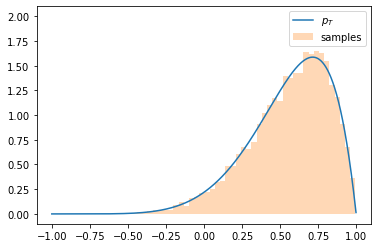

In [3]:
# let's prove that the MarginalT integrates to 1,
# it has gradient, and that the sampling procedure is correct

dim = 5
scale = torch.tensor(5., requires_grad=True)
dist = MarginalTDistribution(dim, scale)

step_size = .001
x = torch.arange(-1, 1, step_size)
y = torch.exp(dist.log_prob(x)).detach()
plt.plot(x, y, label='$p_T$')
print('integal:', y.sum() * step_size)

x = dist.sample((10000,))
plt.hist(x, density=True, bins=50, alpha=.3, label='samples')
print('grad:', torch.autograd.grad(dist.rsample(), dist.scale))

plt.ylim(-.1, 2.1)
plt.xlim(-1.1, 1.1)
plt.legend()
plt.show()

integal: tensor(1.0000)
grad: (tensor([0.0479, 0.0479]), tensor(-0.0040))


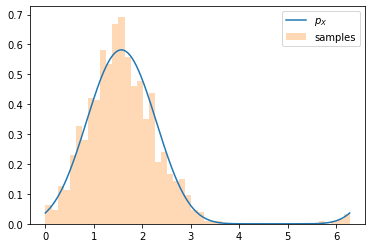

In [4]:
# let's prove that the PowerSpherical integrates to 1, it has gradient,
# and that the sampling procedure is correct

loc = torch.tensor([0., 1.], requires_grad=True)
scale = torch.tensor(4., requires_grad=True)
dist = PowerSpherical(loc, scale)

step_size = .001
x = torch.arange(0, 2 * math.pi, step_size)
pt = torch.stack((torch.cos(x), torch.sin(x))).t()
y = torch.exp(dist.log_prob(pt)).detach()
plt.plot(x, y, label='$p_X$')
print('integal:', y.sum() * step_size)

x = dist.sample((1000,))
plt.hist((lambda v: torch.where(v > 0, v, 2 * math.pi + v))(torch.atan2(x[:,1], x[:,0])),
         density=True, bins=50, alpha=.3, label='samples')

print('grad:', torch.autograd.grad(dist.rsample() @ torch.tensor([math.sqrt(2) / 2, math.sqrt(2) / 2]),
                                   [dist.loc, dist.scale]))

plt.legend()
plt.show()

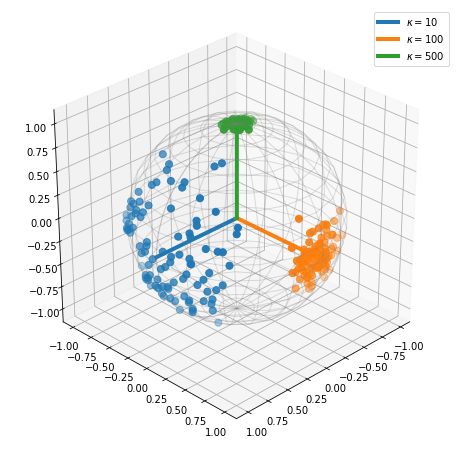

In [5]:
import numpy as np
import mpl_toolkits.mplot3d.axes3d as axes3d

# let's visualize samples in the sphere

theta, phi = np.linspace(0, 2 * np.pi, 20), np.linspace(0, np.pi, 20)
THETA, PHI = np.meshgrid(theta, phi)
X, Y, Z = np.sin(PHI) * np.cos(THETA), np.sin(PHI) * np.sin(THETA), np.cos(PHI)

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
ax.plot_wireframe(X, Y, Z, linewidth=1, alpha=0.25, color="gray")

for loc, scale in zip(torch.eye(3), torch.tensor([10, 100, 500])):
    dist = PowerSpherical(loc, scale)

    X, Y, Z = dist.sample((100,)).T
    ax.scatter(X, Y, Z, s=50)
    ax.plot(*torch.stack((torch.zeros_like(loc), loc)).T, linewidth=4, label="$\kappa={}$".format(scale))

ax.view_init(30, 45)
ax.tick_params(axis='both')
plt.legend()

plt.show()

In [6]:
import quadpy

# let's prove that the distribution integrates to 1 even in higher dimensions (dim=5)

d = 5
loc = torch.tensor([1.] + [0.] * (d - 1))
scale = torch.tensor(5.)
dist = PowerSpherical(loc, scale)

scheme = quadpy.nsphere.stroud_1969(d)

def f(x):
    return dist.log_prob(torch.tensor(x.T, dtype=torch.float32)).exp().detach().numpy()

np.isclose(
    scheme.integrate(f, [0.] * d, radius=1),
    1,
    atol=1e-2,
)

True

In [7]:
# checking mean with MC sampling
dim = 8
loc = torch.tensor([0.] * (dim - 1) + [1.])
scale = torch.tensor(3.)
dist = PowerSpherical(loc, scale)
x = dist.sample((100000,))

torch.isclose(
    x.mean(0),
    dist.mean,
    atol=1e-2,
).all()

tensor(True)

In [8]:
# checking covariance with MC sampling
dim = 8
loc = torch.tensor([0.] * (dim - 1) + [1.])
scale = torch.tensor(3.)
dist = PowerSpherical(loc, scale)
x = dist.sample((100000,))
x = x - x.mean(0)

torch.isclose(
    (x.unsqueeze(-1) @ x.unsqueeze(-2)).mean(0),
    dist.variance,
    atol=1e-2,
).all()

tensor(True)

In [9]:
# checking entropy with MC sampling

dim = 8
loc = torch.tensor([0.] * (dim - 1) + [1.])
scale = torch.tensor(3.)
dist = PowerSpherical(loc, scale)
x = dist.sample((100000,))

torch.isclose(
    -dist.log_prob(x).mean(),
    dist.entropy(),
    atol=1e-2,
).all()

tensor(True)

In [10]:
# checking KL[PowerSpherical; HypersphericalUniform] with MC sampling

dim = 8
loc = torch.tensor([0.] * (dim - 1) + [1.])
scale = torch.tensor(10.)

dist1 = PowerSpherical(loc, scale)
dist2 = HypersphericalUniform(dim)
x = dist1.sample((100000,))

torch.isclose(
    (dist1.log_prob(x) - dist2.log_prob(x)).mean(),
    torch.distributions.kl_divergence(dist1, dist2),
    atol=1e-2,
).all()

tensor(True)